# Determining if Jupyter Notebook is the Right Tool for Students Based on Industry Recognition

Authors:

Tyler Tran, Alec Panattoni

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading in wrangled Kaggle 2020 Survey
survey = pd.read_csv("survey.csv", dtype = 'unicode')
survey = survey.drop(columns = "Unnamed: 0")
survey.head(5)

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28,Q29,Q30,Q31,Q32,Q33,Q34,Q35,Q36,Q37,Q38,Q39
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following hosted notebook product...,What type of computing platform do you use mos...,Which types of specialized hardware do you use...,Approximately how many times have you used a T...,What data visualization libraries or tools do ...,For how many years have you used machine learn...,Which of the following machine learning framew...,Which of the following ML algorithms do you us...,Which categories of computer vision methods do...,Which of the following natural language proces...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,Select any activities that make up an importan...,What is your current yearly compensation (appr...,Approximately how much money have you (or your...,Which of the following cloud computing platfor...,Do you use any of the following cloud computin...,Do you use any of the following machine learni...,Which of the following big data products (rela...,Which of the following big data products (rela...,Which of the following business intelligence t...,Which of the following business intelligence t...,Do you use any automated machine learning tool...,Which of the following automated machine learn...,Do you use any tools to help manage machine le...,Where do you publicly share or deploy your dat...,On which platforms have you begun or completed...,What is the primary tool that you use at work ...,Who/what are your favorite media sources that ...
1,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,"'Python', 'R', 'SQL', 'C', 'Javascript', 'MATL...",Python,"'Jupyter (JupyterLab, Jupyter Notebooks, etc)'...","'Kaggle Notebooks', 'Colab Notebooks'","A cloud computing platform (AWS, Azure, GCP, h...",'GPUs',2-5 times,"'Matplotlib', 'Geoplotlib'",1-2 years,"'TensorFlow', 'Keras', 'Xgboost'","'Decision Trees or Random Forests', 'Gradient ...",'Image classification and other general purpos...,"'Word embeddings/vectors (GLoVe, fastText, wor...",NaN,NaN,NaN,NaN,NaN,NaN,"'Amazon Web Services (AWS)', 'Microsoft Azure'...","'Azure Cloud Services', 'Microsoft Azure Conta...","'Amazon SageMaker', 'Amazon Forecast', 'Amazon...","'MongoDB', 'Microsoft SQL Server', 'Google Clo...",NaN,"'Microsoft Power BI', 'Amazon QuickSight', 'Go...",NaN,"'Automated data augmentation (e.g. imgaug, alb...","'Google Cloud AutoML', 'Databricks AutoML', 'A...",'TensorBoard',NaN,"'Coursera', 'Kaggle Learn Courses', 'Universit...","Basic statistical software (Microsoft Excel, G...","'Kaggle (notebooks, forums, etc)', 'Journal Pu..."
2,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,"'Python', 'R', 'SQL'",Python,"'Visual Studio', 'PyCharm', 'Sublime Text'",'Colab Notebooks',A personal computer or laptop,'GPUs',2-5 times,"'Matplotlib', 'Seaborn', 'Ggplot / ggplot2', '...",1-2 years,"'Scikit-learn', 'TensorFlow', 'Keras', 'PyTorch'","'Linear or Logistic Regression', 'Convolutiona...","'Image segmentation methods (U-Net, Mask R-CNN...","'Contextualized embeddings (ELMo, CoVe)', 'Tra...","10,000 or more employees",20+,"We have well established ML methods (i.e., mod...",'Analyze and understand data to influence prod...,"100,000-124,999","$100,000 or more ($USD)","'Amazon Web Services (AWS)', 'Microsoft Azure'...","'Amazon EC2', 'AWS Lambda', 'Azure Functions',...",'Amazon SageMaker',"'Postgres

In [3]:
# Not counting row with question descriptions
observations = survey.shape[0] - 1

In [4]:
survey["Q24"].unique()

array(['What is your current yearly compensation (approximate $USD)?',
       nan, '100,000-124,999', '15,000-19,999', '125,000-149,999',
       '70,000-79,999', '30,000-39,999', '90,000-99,999', '1,000-1,999',
       '$0-999', '10,000-14,999', '150,000-199,999', '60,000-69,999',
       '4,000-4,999', '> $500,000', '300,000-500,000', '40,000-49,999',
       '25,000-29,999', '80,000-89,999', '7,500-9,999', '50,000-59,999',
       '250,000-299,999', '5,000-7,499', '2,000-2,999', '20,000-24,999',
       '200,000-249,999', '3,000-3,999'], dtype=object)

### Question 1

#### Calculating proportion of survey respondents who used Jupyter.

In [5]:
# Counting missing values as non-Jupyter for proportion calculation
responses = survey["Q9"].str.contains('Jupyter').fillna(value=False).value_counts()
chose_jupyter = responses.get(True)
jupyter_users_prop = chose_jupyter / observations
jupyter_users_prop

0.5595428229187462

In [6]:
def calc_conf_interval90(prop: float, z_score: float, obs: int):
    """Take proportion, z_score, and observation count to calculate
    corresponding confidence interval."""

    interval_low = np.round(prop - (z_score * np.sqrt(prop * (1 - prop) / obs)),
                            decimals = 2)
    interval_high = np.round(prop + (z_score * np.sqrt(prop * (1 - prop) / obs)),
                            decimals = 2)
    return (interval_low, interval_high)


In [7]:
ninety_percent_z = 1.645
jupyter_user_interval = (
    calc_conf_interval90(jupyter_users_prop, ninety_percent_z, observations)
    )
jupyter_user_interval

(0.55, 0.57)

#### Calculating proportion of students who used Jupyter.

In [8]:
students = survey[survey["Q5"] == "Student"]
student_responses = students["Q9"].str.contains('Jupyter').fillna(value=False).value_counts()
s_chose_jupyter = student_responses.get(True)
students_jupyter_prop = s_chose_jupyter / student_responses.sum()
np.round(students_jupyter_prop, decimals = 2)

0.6

In [9]:
student_user_interval = (
    calc_conf_interval90(students_jupyter_prop, ninety_percent_z, student_responses.sum())
    )
student_user_interval

(0.59, 0.61)

#### Calculating proportion of working professionals who used Jupyter

In [10]:
# not counting unemployed
pros = survey[(survey["Q5"] != "Student") & (survey["Q5"] != "Currently not employed")]
pro_responses = pros["Q9"].str.contains('Jupyter').fillna(value=False).value_counts()
pro_chose_jupyter = pro_responses.get(True)
pro_jupyter_prop = pro_chose_jupyter / pro_responses.sum()
np.round(pro_jupyter_prop, decimals = 2)

0.54

In [11]:
pro_user_interval = (
    calc_conf_interval90(pro_jupyter_prop, ninety_percent_z, pro_responses.sum())
    )
pro_user_interval

(0.53, 0.55)

In [12]:
observed_diff = students_jupyter_prop - pro_jupyter_prop
observed_diff

0.056529459255970416

In [13]:
# Bootstrapping for differences
num_bootstraps = 1000
statistics = np.zeros(num_bootstraps)
for boot in range(num_bootstraps):
    student_sample = students.sample(students.shape[0], replace = True)
    student_resp = (student_sample["Q9"]
                   .str.contains('Jupyter')
                   .fillna(value=False).value_counts())
    student_jup = student_resp.get(True)
    student_prop = student_jup / student_resp.sum()
    
    pro_sample = pros.sample(pros.shape[0], replace = True)
    pro_resp = (pro_sample["Q9"]
                   .str.contains('Jupyter')
                   .fillna(value=False).value_counts())
    pro_jup = pro_resp.get(True)
    pro_prop = pro_jup / pro_resp.sum()
    statistics[boot] = student_prop - pro_prop


In [14]:
# Calculate p-value
p_value = np.count_nonzero(statistics >= observed_diff) / num_bootstraps
p_value

0.512

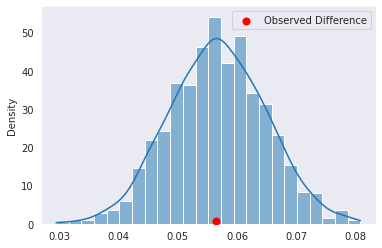

<Figure size 1080x576 with 0 Axes>

In [15]:
# style and display plot
sns.set_style("dark")
sns.histplot(statistics, stat = "density", kde = True)
plt.scatter(observed_diff, 0.75, color = "red", s=50, zorder= 10, label = "Observed Difference")
plt.legend()
plt.figure(figsize=(15,8))
plt.show()

In [16]:
np.min(statistics), np.max(statistics)

(0.029421336822226696, 0.08085449768661002)

### Question 2

In [17]:
from scipy.stats import binom_test

In [18]:
# Subsetting data for us and international users
us_users = survey[survey["Q3"] == "United States of America"]
abroad_users = survey[survey["Q3"] != "United States of America"]

In [19]:
# Getting counts of users who use vs don't use Jupyter for each subset
us_rec_jup = us_users["Q9"].str.contains('Jupyter').fillna(value=False).value_counts()
abroad_rec_jup = abroad_users["Q9"].str.contains('Jupyter').fillna(value=False).value_counts()

us_rec_jup, abroad_rec_jup

(True     1227
 False    1010
 Name: Q9, dtype: int64, True     9984
 False    7816
 Name: Q9, dtype: int64)

In [20]:
abroad_rec_prop = abroad_rec_jup[True] / abroad_rec_jup.sum()
abroad_rec_prop

0.5608988764044944

In [21]:
us_rec_prop = us_rec_jup[True] / us_rec_jup.sum()
us_rec_prop

0.5485024586499776

In [22]:
# Running a binomial test for proportion of Jupyter to see if different than observed abroad rec_prop
binom_test(us_rec_jup[True], n = us_rec_jup.sum(), p = abroad_rec_prop)

0.24137825855143724

In [23]:
# Repeating above procedure after further subsetting for only students
us_students = us_users[us_users["Q5"] == "Student"]
abroad_students = abroad_users[abroad_users["Q5"] == "Student"]

In [24]:
us_student_rec = us_students["Q9"].str.contains('Jupyter').fillna(value=False).value_counts()
abroad_student_rec = abroad_students["Q9"].str.contains('Jupyter').fillna(value=False).value_counts()

In [25]:
abroad_student_rec_prop = abroad_student_rec[True] / abroad_student_rec.sum()
abroad_student_rec_prop

0.6002490660024906

In [26]:
us_student_rec_prop = us_student_rec[True] / us_student_rec.sum()
us_student_rec_prop

0.5495750708215298

In [27]:
binom_test(us_student_rec[True], n = us_student_rec.sum(), p = abroad_student_rec_prop)

0.05709621262461691

### Question 3

In [28]:
from scipy.stats import chi2_contingency

In [29]:
# Subsetting data by experience with ML and then Jupyter with ML
no_ML_exp = survey[survey.get("Q15") == "I do not use machine learning methods"]
ML_exp = survey[(survey.get("Q15") != "I do not use machine learning methods") &
                   (survey.get("Q9") != "Which of the following integrated development environments (IDE's) do you use on a regular basis?  (Select all that apply)")]
jupyter_ML = (ML_exp["Q9"].str.contains(
    'Jupyter').fillna(value=False).value_counts() / len(ML_exp)).get(True)
jupyter_no_ML = (ML_exp["Q9"].str.contains(
    'Jupyter').fillna(value=False).value_counts() / len(ML_exp)).get(True)
MLIDE_counts = {}
MLIDEs = ML_exp.get("Q9")

# Counting experiences for IDEs for users with ML experience
for person in MLIDEs:
    if not isinstance(person, str):
        continue
    for ide in person.split("'"):
        if ide in MLIDE_counts:
            MLIDE_counts[ide] += 1
        else:
            MLIDE_counts[ide] = 1
del MLIDE_counts['']
del MLIDE_counts[', ']
no_MLIDE_counts = {}
no_MLIDEs = no_ML_exp.get("Q9")

# Counting experiences for IDEs for users with no experience
for person in no_MLIDEs:
    if not isinstance(person, str):
        continue
    for ide in person.split("'"):
        if ide in no_MLIDE_counts:
            no_MLIDE_counts[ide] += 1
        else:
            no_MLIDE_counts[ide] = 1
del no_MLIDE_counts['']
del no_MLIDE_counts[', ']
MLIDE_props = {}

# Creating proportions
for ide, count in MLIDE_counts.items():
    MLIDE_props[ide] = count / len(ML_exp)
no_MLIDE_props = {}
for ide, count in no_MLIDE_counts.items():
    no_MLIDE_props[ide] = count / len(no_ML_exp)

# Generating data frame from created ML response data

IDE_props = pd.DataFrame().assign(
    IDE = [ide for ide in MLIDE_props.keys()]
    , MLexperience = [prop for prop in MLIDE_props.values()]
    , noMLexperience = [prop for prop in no_MLIDE_props.values()])
IDE_props = IDE_props.set_index("IDE").sort_values(
    "MLexperience", ascending = False)
IDE_props = IDE_props.assign(difference = IDE_props.get(
    "MLexperience") - IDE_props.get("noMLexperience"))
# Differences in proportions of the two groups appear to 
# be greatest with Jupyter, Pycharm, R, and Vim/Emacs

In [30]:
IDE_props

,MLexperience,noMLexperience,difference
IDE,,,
"Jupyter (JupyterLab, Jupyter Notebooks, etc)",0.578030,0.300723,0.277307
Visual Studio Code (VSCode),0.292244,0.197108,0.095136
PyCharm,0.256612,0.399518,-0.142907
RStudio,0.193363,0.084819,0.108544
Spyder,0.170035,0.122892,0.047144
Notepad++,0.151606,0.089639,0.061968
Sublime Text,0.122321,0.170120,-0.047800
Visual Studio,0.119704,0.052530,0.067174
MATLAB,0.082512,0.058795,0.023717


In [31]:
# Creating contingency table
ML_prop = len(ML_exp) / (len(survey) - 1)
no_ML_prop = len(no_ML_exp) / (len(survey) - 1)
Jupyter = chose_jupyter
VScode = survey["Q9"].str.contains(
    'VSCode').fillna(value=False).value_counts().get(True)
Pycharm = survey["Q9"].str.contains(
    'PyCharm').fillna(value=False).value_counts().get(True)
NotePad = VScode = survey["Q9"].str.contains(
    'Notepad').fillna(value=False).value_counts().get(True)
R = survey["Q9"].str.contains(
    'RStudio').fillna(value=False).value_counts().get(True)
VStudio = survey[survey["Q9"].str.contains(
    'Visual Studio').fillna(value=False)]
VStudio = VStudio["Q9"].str.contains(
    'VSCode', na=False).value_counts().get(True)
Sublime = survey["Q9"].str.contains(
    'Sublime').fillna(value=False).value_counts().get(True)
Spyder = survey["Q9"].str.contains(
    'Spyder').fillna(value=False).value_counts().get(True)
Other = survey["Q9"].str.contains(
    'Other').fillna(value=False).value_counts().get(True)
none = survey["Q9"].str.contains(
    'None').fillna(value=False).value_counts().get(True)
matlab = survey["Q9"].str.contains(
    'MATLAB').fillna(value=False).value_counts().get(True)
vimemacs = survey["Q9"].str.contains(
    'Emacs').fillna(value=False).value_counts().get(True)
ide_counts_ = [VScode, NotePad, Sublime, vimemacs, Jupyter, R, none
                 , Pycharm, Other, matlab, Spyder, VStudio]
ide_counts = [Jupyter, VScode, Spyder, VStudio, Pycharm, Sublime, R
              , vimemacs, NotePad, matlab, none, Other]
obsvsexp = pd.DataFrame().assign(IDE = [ide for ide in MLIDE_counts.keys()]
           , MLobs = [obs for obs in MLIDE_counts.values()]
           , MLexp = [math.ceil((count * ML_prop)) for count in ide_counts]
           , noMLobs = [obs for obs in no_MLIDE_counts.values()]
           , noMLexp = [math.ceil(count * no_ML_prop) for count in ide_counts_]
           ).sort_values(by = 'MLexp', ascending = False).set_index("IDE")

In [32]:
obsvsexp

,MLobs,MLexp,noMLobs,noMLexp
IDE,,,,
"Jupyter (JupyterLab, Jupyter Notebooks, etc)",10382,10050,624,325
Visual Studio,2150,5265,109,156
PyCharm,4609,4571,829,1162
RStudio,3473,3430,176,40
Spyder,3054,2950,255,254
Visual Studio Code (VSCode),5249,2808,409,325
Notepad++,2723,2808,186,121
Sublime Text,2197,2199,353,397
MATLAB,1482,1438,122,167


In [33]:
# Chi Squared test of independence
chi_sq = chi2_contingency([obsvsexp.get("MLobs"), obsvsexp.get("noMLobs")])
chi_sq

(2486.1669381674246,
 0.0,
 11,
 array([[9935.33866895, 2039.24496213, 4908.9925206 , 3294.02605879,
         2987.10118622, 5107.59096756, 2626.01310085, 2301.93654423,
         1447.96322233, 1699.82216188, 1147.35739126,  402.61321519],
        [1070.66133105,  219.75503787,  529.0074794 ,  354.97394121,
          321.89881378,  550.40903244,  282.98689915,  248.06345577,
          156.03677767,  183.17783812,  123.64260874,   43.38678481]]))

### Question 4


In [34]:
uses_jupyter = survey["Q9"].str.contains('Jupyter').fillna(value=False)
# create df with Years Experience and binary indicator for uses Jupyter
exp_jupyter = survey.assign(Jupyter = uses_jupyter)[["Q6", "Jupyter"]]
exp_jupyter = exp_jupyter[exp_jupyter.get(
    "Q6") != "For how many years have you been writing code and/or programming?"].dropna().rename(
    columns = {"Q6": "Years Experience"})
exp_jupyter["Jupyter"] = (exp_jupyter['Jupyter'] == True).astype(int)
# export df to R to generate logistic model
exp_jupyter.to_csv("exp_jupyter.csv")

In [35]:
exp_jupyter

,Years Experience,Jupyter
1,5-10 years,1
2,5-10 years,0
3,10-20 years,0
4,5-10 years,0
5,3-5 years,0
...,...,...
20030,10-20 years,0
20033,20+ years,1
20034,< 1 years,1
20035,3-5 years,1


In [36]:
# numbers generated from log model done in R
def predict_jupyter_odds(yrs):
    intercept = 0.49845
    if isinstance(yrs, str):
        if (yrs == "< 1 years"):
            return intercept
        if yrs == "I have never written code":
            return 0
        if yrs == "1-2 years":
            return intercept + 0.11742
        if yrs == "10-20 years":
            return intercept - 0.20043
        if yrs == "20+ years":
            return intercept - 0.32798
        if yrs == "3-5 years":
            return intercept + 0.09852
        if yrs == "5-10 years":
            return intercept - 0.03417
    elif (isinstance(yrs, int) or isinstance(yrs, float)) and (yrs >= 0):
        if ((yrs > 0) and (yrs < 1)):
            return intercept
        if yrs == 0:
            return 0
        if (yrs >= 1) and (yrs < 3):
            return intercept + 0.11742
        if (yrs >= 10) and (yrs < 20):
            result = intercept - 0.20043
            if result < 0:
                result = 0
            return result
        if yrs >= 20:
            result = intercept - 0.32798
            if result < 0:
                result = 0
            return result 
        if (yrs >= 3) and (yrs < 5):
            return intercept + 0.09852
        if (yrs >= 5) and (yrs < 10):
            result = intercept - 0.03417
            if result < 0:
                result = 0
            return result
    else:
        return "not a valid input"

In [37]:
# apply predictions to all observations
with_predict = exp_jupyter.assign(binary = exp_jupyter.get(
    "Years Experience").apply(predict_jupyter_odds)).rename(columns = {
        "binary":"Uses Jupyter Prediction"})
# create predictions for each programming years experience subgroup
with_predict.groupby("Years Experience").mean()[["Uses Jupyter Prediction"]].sort_values(
    "Uses Jupyter Prediction")

,Uses Jupyter Prediction
Years Experience,
I have never written code,0.00000
20+ years,0.17047
10-20 years,0.29802
5-10 years,0.46428
< 1 years,0.49845
3-5 years,0.59697
1-2 years,0.61587


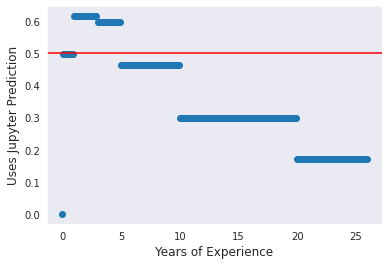

In [38]:
# create visualization for predictions
willplot = pd.DataFrame().assign(ages = np.arange(0,26, 0.1))
willplot = willplot.assign(prop_preferred_ide = willplot.get("ages").apply(predict_jupyter_odds)).rename(
    columns = {"prop_preferred_ide": "predicted uses Jupyter"})
plt.scatter(willplot.get("ages"), willplot.get(
    "predicted uses Jupyter"))
plt.xlabel('Years of Experience', fontsize = 12)
plt.ylabel('Uses Jupyter Prediction', fontsize = 12)
plt.axhline(y = 0.5, color = 'red')

### Question 5 (Advanced Analysis)


In [39]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score
from sklearn.metrics import f1_score, classification_report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [40]:
naive_bayes_qs = survey[["Q4","Q5", "Q6","Q9"]]
naive_bayes_qs = naive_bayes_qs.drop(0)

In [41]:
naive_bayes_qs["Q9"].loc[(naive_bayes_qs["Q9"].str.contains('Jupyter').fillna(value = False))] = 1
naive_bayes_qs["Q9"].loc[(naive_bayes_qs["Q9"]) != True] = 0
naive_bayes = naive_bayes_qs.dropna().rename(columns = 
                                             ({"Q5": "Occupation", "Q9": "Use Jupyter",
                                              "Q4": "Education", "Q6": "Experience"}))

In [42]:
features = naive_bayes.columns.tolist()
features = [features[0]] + [features[2]]
features

['Education', 'Experience']

In [43]:
le = preprocessing.LabelEncoder()
ordin = preprocessing.OrdinalEncoder()
features_encoded = ordin.fit_transform(naive_bayes[features])
occupation_encoded = le.fit_transform(naive_bayes["Occupation"])
#educ_encoded = le.fit_transform(naive_bayes["Education"])
#code_exp_encoded = le.fit_transform(naive_bayes["Experience"])
jup_encoded = le.fit_transform(naive_bayes["Use Jupyter"])

In [44]:
naive_bayes_encoded = pd.DataFrame(features_encoded,columns = features)
#naive_bayes_encoded["Education"] = educ_encoded
naive_bayes_encoded["Occupation"] = occupation_encoded
#naive_bayes_encoded["Experience"] = code_exp_encoded
naive_bayes_encoded["Use Jupyter"] = jup_encoded


In [45]:
naive_bayes_encoded

,Education,Experience,Occupation,Use Jupyter
0,1.0,4.0,12,1
1,3.0,4.0,4,0
2,0.0,1.0,10,0
3,3.0,4.0,5,0
4,3.0,3.0,10,0
...,...,...,...,...
19115,0.0,1.0,7,0
19116,3.0,2.0,1,1
19117,3.0,5.0,9,1
19118,0.0,3.0,10,1


In [46]:
# Checking Naive Assumptions (if features are too highly correlated, can't do naive bayes)
vif = pd.DataFrame()
vif["Features"] = features + ["Occupation"]
vif["VIF"] = [variance_inflation_factor(naive_bayes_encoded.values, i) for i in range(len(features ) + 1)]

In [47]:
vif

,Features,VIF
0,Education,1.870727
1,Experience,2.195272
2,Occupation,2.630192


In [48]:
X_train, X_test, y_train, y_test = train_test_split(naive_bayes_encoded.drop("Use Jupyter", axis = 1), 
                                                   naive_bayes_encoded["Use Jupyter"], test_size = 0.25)

In [49]:
cnb = CategoricalNB()
cnb.fit(X_train, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [50]:
y_pred_cnb = cnb.predict(X_test)
y_prob_pred_cnb = cnb.predict_proba(X_test)

In [51]:
count_misclassified = (y_test != y_pred_cnb).sum()

In [52]:
print("CategoricalNB")
print("=" * 30)
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(y_test, y_pred_cnb)
print('Accuracy: {:.2f}'.format(accuracy))

CategoricalNB
Misclassified samples: 1654
Accuracy: 0.65


In [53]:
print("Recall score : ", recall_score(y_test, y_pred_cnb , average='micro'))
print("Precision score : ",precision_score(y_test, y_pred_cnb , average='micro'))
print("F1 score : ",f1_score(y_test, y_pred_cnb , average='micro'))

Recall score :  0.6539748953974895
Precision score :  0.6539748953974895
F1 score :  0.6539748953974895


In [54]:
print(classification_report(y_test, y_pred_cnb))

              precision    recall  f1-score   support

           0       0.67      0.29      0.40      1939
           1       0.65      0.90      0.76      2841

    accuracy                           0.65      4780
   macro avg       0.66      0.60      0.58      4780
weighted avg       0.66      0.65      0.61      4780



In [55]:
y_pred_cnb.size

4780